# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [89]:
from __future__ import print_function, division
from skimage import color
import scipy.misc
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

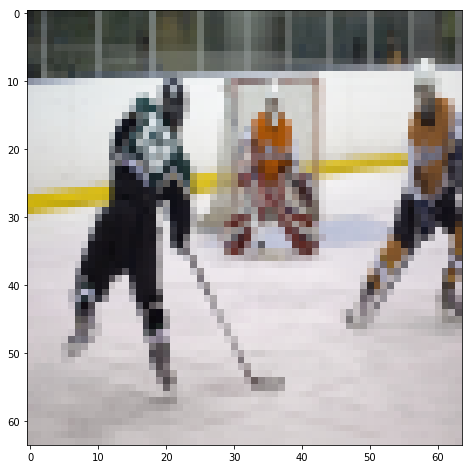

In [90]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(idx, img_size='64x64'):
    NUM_LOAD = 15000
    data_file = './train_data_batch_'

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']

    x = x/np.float32(255)
    y = [i-1 for i in y]
    data_size = x.shape[0]
    x = np.dstack((x[:, :4096], x[:, 4096:8192], x[:, 8192:]))
    x = x.reshape((x.shape[0], 64, 64, 3))

    X_train = x[0:NUM_LOAD, :, :, :]
    Y_train = y[0:NUM_LOAD]
    return X_train

def rgb_to_lab(data):
    length = data.shape[0]
    dim = data.shape[1]
    lab_data = np.array([color.rgb2lab(data[i]) for i in range(length)])
    X = np.copy(lab_data[:, :, :, 0].reshape((length, dim, dim, 1)))
    Y = np.copy(np.concatenate((lab_data[:, :, :, 1].reshape((length,dim,dim,1)), lab_data[:, :, :, 2].reshape((length,dim,dim,1))), axis=3))
    return X, Y

X_all = load_databatch(1)
plt.imshow(X_all[0])
plt.show

NUM_TRAIN = 10000
NUM_VAL = 100
NUM_TEST = 100

X_train_RGB = np.copy(X_all[:NUM_TRAIN])
X_val_RGB = np.copy(X_all[NUM_TRAIN:NUM_TRAIN+NUM_VAL])
X_test_RGB = np.copy(X_all[NUM_TRAIN+NUM_VAL:NUM_TRAIN+NUM_VAL+NUM_TEST])

X_t_l, Y_t_ab = rgb_to_lab(X_train_RGB)
X_v_l, Y_v_ab = rgb_to_lab(X_val_RGB)
X_test_l, Y_test_ab = rgb_to_lab(X_test_RGB)
Training = True


## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [91]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha * x, x)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [92]:
def conv(batch_input, out_channels, stride):
    with tf.variable_scope("conv"):

        in_channels = 0
        if type(batch_input) is np.ndarray:
            in_channels = batch_input.shape[3]
        else:
            in_channels = batch_input.get_shape()[3]
        filter = tf.get_variable("filter", [4, 4, in_channels, out_channels], dtype=tf.float32, initializer=tf.random_normal_initializer(0, 0.02))
        # [batch, in_height, in_width, in_channels], [filter_width, filter_height, in_channels, out_channels]
        #     => [batch, out_height, out_width, out_channels]
        padded_input = tf.pad(batch_input, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT")
        conv = tf.nn.conv2d(padded_input, filter, [1, stride, stride, 1], padding="VALID")
        return conv

def discriminator(x, y):
    with tf.variable_scope("discriminator"):
        input = tf.cast(tf.concat([x, y], axis=3), tf.float32)
        n_layers = 2
        layers = []

        # layer_1: [batch, 64, 64, in_channels * 3] => [batch, 32, 32, 64]
        with tf.variable_scope("layer_1"):
            convolved = conv(input, 64, stride=2)
            rectified = leaky_relu(convolved, 0.2)
            layers.append(rectified)

        # layer_2: [batch, 32, 32, 64] => [batch, 16, 16, 128]
        # layer_3: [batch, 16, 16, 128] => [batch, 15, 15, 256]

        for i in range(n_layers):
            with tf.variable_scope("layer_%d" % (len(layers) + 1)):
                out_channels = 64 * (2**(i+1))
                stride = 1 if i == n_layers - 1 else 2  # last layer here has stride 1
                convolved = conv(layers[-1], out_channels, stride=stride)
                normalized = tf.layers.batch_normalization(convolved, training = Training)
                rectified = leaky_relu(normalized, 0.2)
                layers.append(rectified)

        # layer_4: [batch, 15, 15, 256] => [batch, 30, 30, 1]
        with tf.variable_scope("layer_%d" % (len(layers) + 1)):
            convolved = conv(rectified, out_channels=1, stride=1)
            output = tf.sigmoid(convolved)
            layers.append(output)

        return layers[-1]


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [93]:
def deconv(batch_input, out_channels):
    with tf.variable_scope("deconv"):
        batch, in_height, in_width, in_channels = [int(d) for d in batch_input.get_shape()]
        filter = tf.get_variable("filter", [4, 4, out_channels, in_channels], dtype=tf.float32, initializer=tf.random_normal_initializer(0, 0.02))
        # [batch, in_height, in_width, in_channels], [filter_width, filter_height, out_channels, in_channels]
        #     => [batch, out_height, out_width, out_channels]
        conv = tf.nn.conv2d_transpose(batch_input, filter, [batch, in_height * 2, in_width * 2, out_channels], [1, 2, 2, 1], padding="SAME")
        return conv

def generator(generator_inputs, generator_outputs_channels = 2):
    with tf.variable_scope("generator"):

        layers = []

        # encoder_1: [batch, 64, 64, in_channels] => [batch, 32, 32, 64]
        with tf.variable_scope("encoder_1"):
            output = conv(tf.cast(generator_inputs, tf.float32), 64, stride=2)
            layers.append(output)

        layer_specs = [
            128, # encoder_2: [batch, 32, 32, 64] => [batch, 16, 16, 128]
            256, # encoder_3: [batch, 16, 16, 128] => [batch, 8, 8, 256]
            512, # encoder_4: [batch, 8, 8, 256] => [batch, 4, 4, 512]
            512, # encoder_5: [batch, 4, 4, 512] => [batch, 2, 2, 512]
            512 # encoder_6: [batch, 2, 2, 512] => [batch, , 1, 512]
        ]

        for out_channels in layer_specs:
            with tf.variable_scope("encoder_%d" % (len(layers) + 1)):
                rectified = leaky_relu(layers[-1], 0.2)
                # [batch, in_height, in_width, in_channels] => [batch, in_height/2, in_width/2, out_channels]
                convolved = conv(rectified, out_channels, stride=2)
                output = tf.layers.batch_normalization(convolved)
                layers.append(output)

        layer_specs = [
            (512, 0.5),   # decoder_6: [batch, 1, 1, 512] => [batch, 2, 2, 512 * 2]
            (512, 0.5),   # decoder_5: [batch, 2, 2, 512 * 2] => [batch, 4, 4, 512 * 2]
            (512, 0.5),   # decoder_4: [batch, 4, 4, 512 * 2] => [batch, 8, 8, 512 * 2]
            (256, 0.0),   # decoder_3: [batch, 8, 8, 512 * 2] => [batch, 16, 16, 256 * 2]
            (128, 0.0),   # decoder_2: [batch, 16, 16, 256 * 2] => [batch, 32, 32, 128 * 2]
        ]

        num_encoder_layers = len(layers)
        for decoder_layer, (out_channels, dropout) in enumerate(layer_specs):
            skip_layer = num_encoder_layers - decoder_layer - 1
            with tf.variable_scope("decoder_%d" % (skip_layer + 1)):
                if decoder_layer == 0:
                    # first decoder layer doesn't have skip connections
                    # since it is directly connected to the skip_layer
                    input = layers[-1]
                else:
                    input = tf.concat([layers[-1], layers[skip_layer]], axis=3)

                rectified = tf.nn.relu(input)
                # [batch, in_height, in_width, in_channels] => [batch, in_height*2, in_width*2, out_channels]
                output = deconv(rectified, out_channels)
                output = tf.layers.batch_normalization(output)

                if dropout > 0.0:
                    output = tf.nn.dropout(output, keep_prob=1 - dropout)

                layers.append(output)

        # decoder_1: [batch, 32, 32, 128] => [batch, 64, 64, generator_outputs_channels]
        with tf.variable_scope("decoder_1"):
            input = tf.concat([layers[-1], layers[0]], axis=3)
            rectified = tf.nn.relu(input)
            output = deconv(rectified, generator_outputs_channels)
            output = tf.tanh(output)
            layers.append(output)

        return layers[-1]


Make sure noise is the correct shape and type:

In [94]:
def gan_loss(outputs, targets, real, fake):
    EPS = 1e-12
    l1_weight = 100.0
    gan_weight = 1.0
    discrim_loss = tf.reduce_mean(-(tf.log(real + EPS) + tf.log(1 - fake + EPS)))
    gen_loss_GAN = tf.reduce_mean(-tf.log(fake + EPS))
    gen_loss_L1 = tf.reduce_mean(tf.abs(targets - outputs))
    gen_loss = gen_loss_GAN * gan_weight + gen_loss_L1 * l1_weight
    return discrim_loss, gen_loss


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [95]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    return D_solver, G_solver


Test to make sure the number of parameters in the discriminator is correct:

In [96]:
tf.reset_default_graph()

batch_size = 1
xVals = tf.placeholder(tf.float32, [1, 64, 64, 1])
yVals = tf.placeholder(tf.float32, [1, 64, 64, 2])
G_sample = generator(xVals)
with tf.variable_scope("") as scope:
    fake = discriminator(xVals, G_sample)
    scope.reuse_variables()
    real = discriminator(xVals, yVals)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(G_sample, yVals, real, fake)

    # setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [97]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, show_every=250, print_every=1000, save_every=1000, batch_size=1, num_epoch=10):
    max_iter = int(NUM_TRAIN * num_epoch/batch_size)
    d_losses = []
    g_losses = []

    for it in range(max_iter):
        minibatch, minbatch_y = X_t_l[it%NUM_TRAIN].reshape(1,64,64,1), Y_t_ab[it%NUM_TRAIN].reshape(1,64,64,2)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict = {xVals: minibatch, yVals: minbatch_y})
        _, G_loss_curr, outputImage = sess.run([G_train_step, G_loss, G_sample], feed_dict = {xVals: minibatch, yVals: minbatch_y})
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)

        # every show often, show a sample result
        if it % show_every == 0:
            samples = np.concatenate((X_t_l[it].reshape((64, 64, 1)), outputImage.reshape((64, 64, 2))), axis = 2)
            figure = color.lab2rgb(samples)
            plt.imshow(figure)
            plt.show
            scipy.misc.imsave('output-train-images/' + str(it) + '.jpg', figure)
            print("Image saved")

        # Save model every so often
        if it % save_every == 0:
            saver = tf.train.Saver()
            model_path = 'models/generator_%s' % str(it)
            saver.save(sess, model_path)
            print("Checkpoint saved")

        if it == max_iter - 1:
            saver = tf.train.Saver()
            model_path = 'models/final'
            saver.save(sess, model_path)
            print("Final checkpoint saved; training finished")

        # print loss every so often.

        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (6,4)
    plt.plot(d_losses)
    plt.grid(True)
    plt.title('Discriminator Training Loss Convergence')
    plt.xlabel('Iteration Number')
    plt.ylabel('D-Loss')
    plt.show()

    plt.plot(g_losses)
    plt.grid(True)
    plt.title('Generator Training Loss Convergence')
    plt.xlabel('Iteration Number')
    plt.ylabel('G-Loss')
    plt.show()


            Test to make sure the number of parameters in the generator is correct:

Image saved
Checkpoint saved
Iter: 0, D: 1.56, G:372.1
Image saved
Image saved
Image saved
Final checkpoint saved; training finished


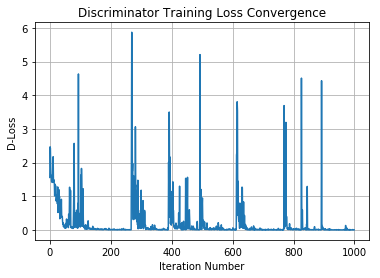

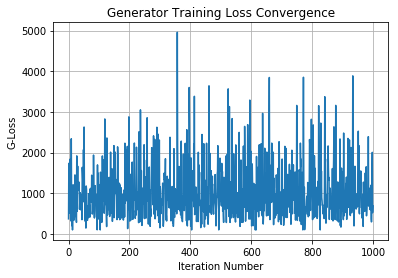

In [98]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [99]:
Training = False

def test_a_gan(sess):
    saver = tf.train.Saver()
    saver.restore(sess, 'models/final')

    for it in range(NUM_TEST):
        minibatch, minbatch_y = X_test_l[it].reshape(1,64,64,1), Y_test_ab[it].reshape(1,64,64,2)
        outputImage = sess.run(G_sample, feed_dict = {xVals: minibatch, yVals: minbatch_y})

        samples = np.concatenate((X_test_l[it].reshape((64, 64, 1)), outputImage.reshape((64, 64, 2))), axis = 2)
        figure = color.lab2rgb(samples)
        plt.imshow(figure)
        plt.show
        scipy.misc.imsave('output-test-images/' + str(it) + '.jpg', figure)
        print("Image saved")


Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

INFO:tensorflow:Restoring parameters from models/final


INFO:tensorflow:Restoring parameters from models/final


Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Image saved
Imag

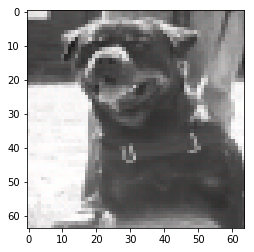

In [100]:
with get_session() as sess:
    test_a_gan(sess)

# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [ ]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [ ]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [ ]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

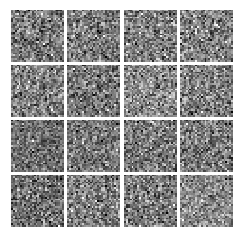


Iter: 0, D: 1.501, G:0.7591
Iter: 50, D: 0.4307, G:1.607
Iter: 100, D: 1.51, G:2.165
Iter: 150, D: 2.06, G:0.9864
Iter: 200, D: 0.8966, G:1.322


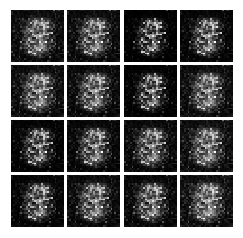


Iter: 250, D: 1.04, G:1.419
Iter: 300, D: 1.206, G:1.735
Iter: 350, D: 1.357, G:1.165
Iter: 400, D: 1.536, G:1.303
Iter: 450, D: 1.227, G:1.154


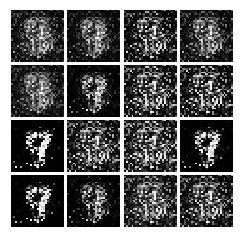


Iter: 500, D: 0.6633, G:2.169
Iter: 550, D: 1.339, G:1.115
Iter: 600, D: 1.649, G:0.2619
Iter: 650, D: 1.167, G:0.7016
Iter: 700, D: 1.031, G:1.222


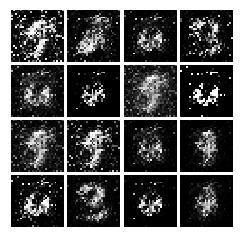


Iter: 750, D: 1.311, G:0.7486
Iter: 800, D: 1.14, G:1.133
Iter: 850, D: 1.29, G:1.132
Iter: 900, D: 1.23, G:1.253
Iter: 950, D: 0.8791, G:1.671


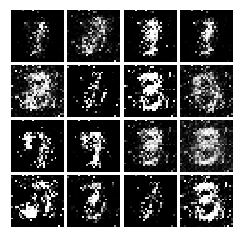


Iter: 1000, D: 1.291, G:2.485
Iter: 1050, D: 1.194, G:1.163
Iter: 1100, D: 0.8853, G:1.477
Iter: 1150, D: 1.237, G:1.068
Iter: 1200, D: 1.453, G:0.812


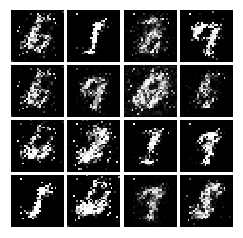


Iter: 1250, D: 1.295, G:0.9618
Iter: 1300, D: 1.088, G:1.066
Iter: 1350, D: 1.13, G:1.01
Iter: 1400, D: 1.293, G:1.011
Iter: 1450, D: 1.291, G:1.072


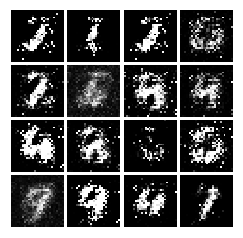


Iter: 1500, D: 1.203, G:1.177
Iter: 1550, D: 1.286, G:0.8739
Iter: 1600, D: 1.272, G:0.8351
Iter: 1650, D: 2.434, G:0.6577
Iter: 1700, D: 1.294, G:1.079


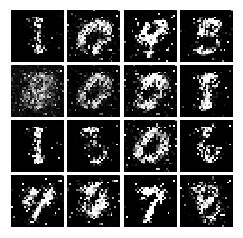


Iter: 1750, D: 1.248, G:0.918
Iter: 1800, D: 1.302, G:1.087
Iter: 1850, D: 1.254, G:0.9427
Iter: 1900, D: 1.182, G:1.016
Iter: 1950, D: 1.28, G:0.5458


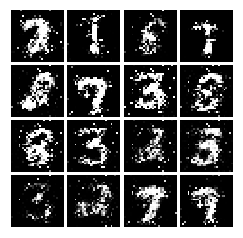


Iter: 2000, D: 1.342, G:0.9511
Iter: 2050, D: 1.263, G:0.8925
Iter: 2100, D: 1.327, G:1.139
Iter: 2150, D: 1.233, G:0.7554
Iter: 2200, D: 1.271, G:0.889


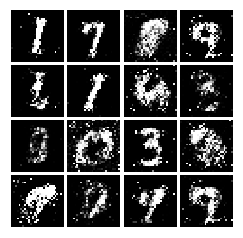


Iter: 2250, D: 1.28, G:0.8348
Iter: 2300, D: 1.233, G:0.9955
Iter: 2350, D: 1.35, G:0.8228
Iter: 2400, D: 1.25, G:0.8612
Iter: 2450, D: 1.284, G:0.8133


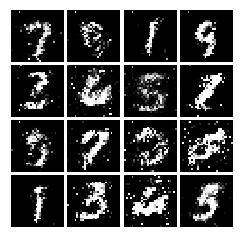


Iter: 2500, D: 1.351, G:0.971
Iter: 2550, D: 1.34, G:0.7751
Iter: 2600, D: 1.322, G:0.8734
Iter: 2650, D: 1.304, G:0.8016
Iter: 2700, D: 1.329, G:0.8469


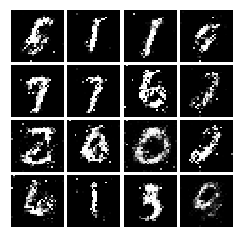


Iter: 2750, D: 1.291, G:0.6594
Iter: 2800, D: 1.346, G:0.8221
Iter: 2850, D: 1.33, G:0.8064
Iter: 2900, D: 1.268, G:0.8353
Iter: 2950, D: 1.252, G:0.5633


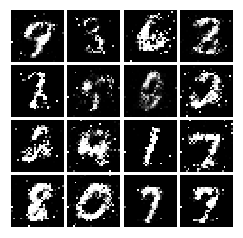


Iter: 3000, D: 1.245, G:0.9305
Iter: 3050, D: 1.376, G:0.792
Iter: 3100, D: 1.241, G:0.9544
Iter: 3150, D: 1.374, G:0.725
Iter: 3200, D: 1.336, G:0.8245


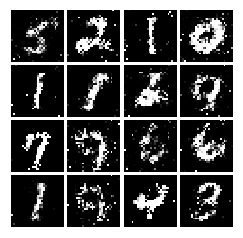


Iter: 3250, D: 1.228, G:0.9568
Iter: 3300, D: 1.235, G:0.8006
Iter: 3350, D: 1.251, G:0.8625
Iter: 3400, D: 1.259, G:0.8597
Iter: 3450, D: 1.331, G:0.7839


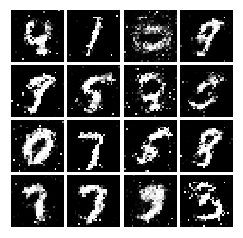


Iter: 3500, D: 1.344, G:0.7832
Iter: 3550, D: 1.297, G:0.928
Iter: 3600, D: 1.251, G:0.9175
Iter: 3650, D: 1.331, G:0.7974
Iter: 3700, D: 1.287, G:0.8877


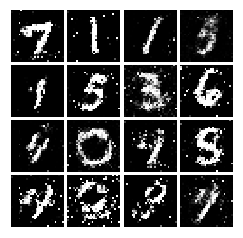


Iter: 3750, D: 1.353, G:0.8434
Iter: 3800, D: 1.277, G:0.8248
Iter: 3850, D: 1.263, G:0.8532
Iter: 3900, D: 1.341, G:0.7651
Iter: 3950, D: 1.304, G:0.7643


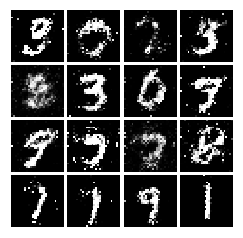


Iter: 4000, D: 1.357, G:0.9501
Iter: 4050, D: 1.253, G:0.8462
Iter: 4100, D: 1.289, G:0.8076
Iter: 4150, D: 1.344, G:0.8936
Iter: 4200, D: 1.261, G:0.8359


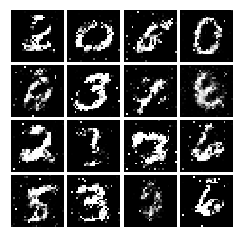


Iter: 4250, D: 1.292, G:0.9071
Final images


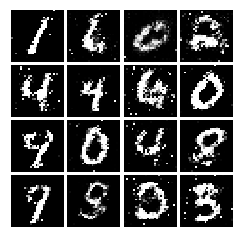

In [232]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [233]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    temp1 = 0.5 * tf.reduce_mean(tf.square(score_real - tf.ones_like(score_real)))
    temp2 = 0.5 * tf.reduce_mean(tf.square(score_fake))
    D_loss = (temp1 + temp2) 
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake - tf.ones_like(score_fake)))
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [234]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [235]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

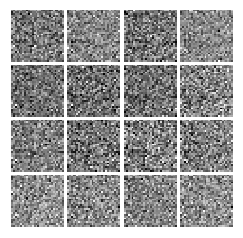


Iter: 0, D: 0.7025, G:0.3137
Iter: 50, D: 0.04185, G:0.7416
Iter: 100, D: 0.03283, G:0.612
Iter: 150, D: 0.2448, G:0.7817
Iter: 200, D: 0.3055, G:0.7011


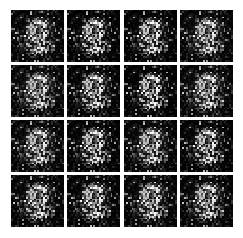


Iter: 250, D: 0.2356, G:0.6835
Iter: 300, D: 0.1316, G:0.8977
Iter: 350, D: 0.08596, G:0.4144
Iter: 400, D: 0.06851, G:0.5759
Iter: 450, D: 0.106, G:0.4469


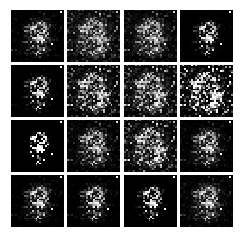


Iter: 500, D: 0.1799, G:0.4684
Iter: 550, D: 0.07591, G:0.3016
Iter: 600, D: 0.1256, G:0.3984
Iter: 650, D: 0.1706, G:0.4024
Iter: 700, D: 0.1388, G:0.3535


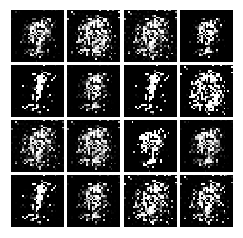


Iter: 750, D: 0.1349, G:0.7078
Iter: 800, D: 0.1196, G:0.4296
Iter: 850, D: 0.1258, G:0.7833
Iter: 900, D: 0.1736, G:0.4213
Iter: 950, D: 0.2115, G:0.2647


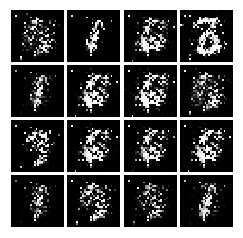


Iter: 1000, D: 0.1397, G:0.2711
Iter: 1050, D: 0.1586, G:0.2721
Iter: 1100, D: 0.1696, G:0.2362
Iter: 1150, D: 0.1893, G:0.3963
Iter: 1200, D: 0.1881, G:0.2858


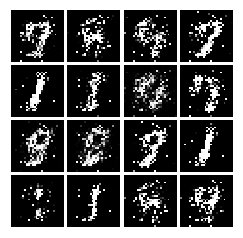


Iter: 1250, D: 0.1862, G:0.2221
Iter: 1300, D: 0.1558, G:0.3177
Iter: 1350, D: 0.1851, G:0.2549
Iter: 1400, D: 0.1473, G:0.2787
Iter: 1450, D: 0.1892, G:0.3146


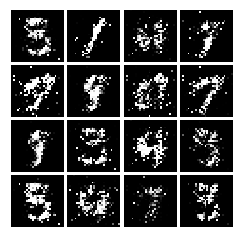


Iter: 1500, D: 0.2386, G:0.05061
Iter: 1550, D: 0.1904, G:0.2485
Iter: 1600, D: 0.1881, G:0.2139
Iter: 1650, D: 0.1863, G:0.2512
Iter: 1700, D: 0.1978, G:0.2346


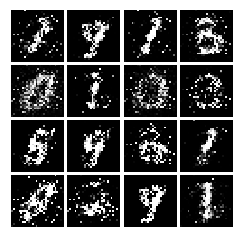


Iter: 1750, D: 0.2162, G:0.2056
Iter: 1800, D: 0.2003, G:0.2328
Iter: 1850, D: 0.2038, G:0.2032
Iter: 1900, D: 0.2101, G:0.1925
Iter: 1950, D: 0.2302, G:0.2211


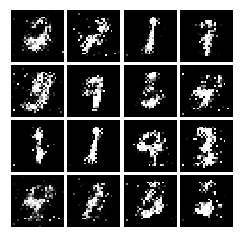


Iter: 2000, D: 0.1917, G:0.2224
Iter: 2050, D: 0.1931, G:0.2423
Iter: 2100, D: 0.2038, G:0.2151
Iter: 2150, D: 0.1831, G:0.2435
Iter: 2200, D: 0.2056, G:0.1889


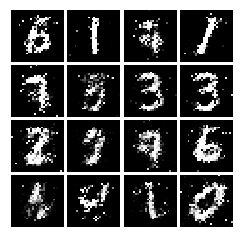


Iter: 2250, D: 0.1845, G:0.2272
Iter: 2300, D: 0.244, G:0.1626
Iter: 2350, D: 0.2152, G:0.1747
Iter: 2400, D: 0.1995, G:0.1995
Iter: 2450, D: 0.2335, G:0.162


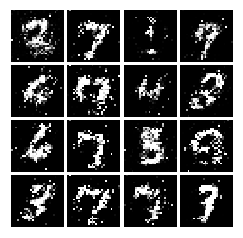


Iter: 2500, D: 0.2398, G:0.1864
Iter: 2550, D: 0.2227, G:0.2349
Iter: 2600, D: 0.2225, G:0.1888
Iter: 2650, D: 0.1972, G:0.2325
Iter: 2700, D: 0.2296, G:0.2021


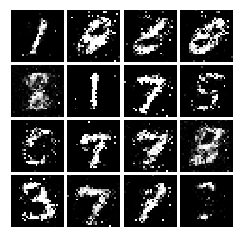


Iter: 2750, D: 0.2443, G:0.1672
Iter: 2800, D: 0.2224, G:0.192
Iter: 2850, D: 0.2232, G:0.1682
Iter: 2900, D: 0.2047, G:0.1959
Iter: 2950, D: 0.2088, G:0.1737


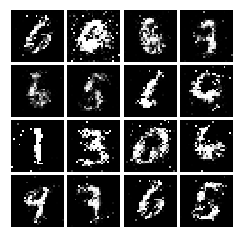


Iter: 3000, D: 0.2147, G:0.182
Iter: 3050, D: 0.2203, G:0.1807
Iter: 3100, D: 0.2111, G:0.1802
Iter: 3150, D: 0.2226, G:0.1665
Iter: 3200, D: 0.2383, G:0.2007


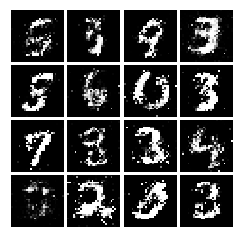


Iter: 3250, D: 0.2253, G:0.168
Iter: 3300, D: 0.1996, G:0.1901
Iter: 3350, D: 0.2379, G:0.1674
Iter: 3400, D: 0.2306, G:0.1641
Iter: 3450, D: 0.2392, G:0.1896


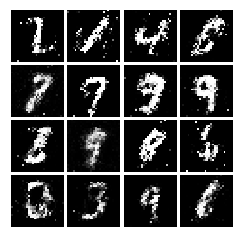


Iter: 3500, D: 0.2067, G:0.2025
Iter: 3550, D: 0.2351, G:0.2016
Iter: 3600, D: 0.2089, G:0.1827
Iter: 3650, D: 0.2513, G:0.1723
Iter: 3700, D: 0.2062, G:0.218


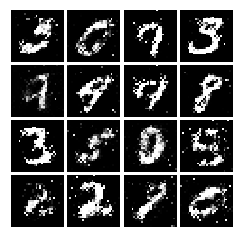


Iter: 3750, D: 0.2115, G:0.1954
Iter: 3800, D: 0.2261, G:0.1823
Iter: 3850, D: 0.2185, G:0.1847
Iter: 3900, D: 0.1985, G:0.1907
Iter: 3950, D: 0.2167, G:0.209


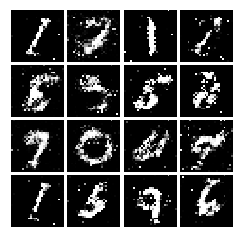


Iter: 4000, D: 0.1967, G:0.1586
Iter: 4050, D: 0.2084, G:0.1717
Iter: 4100, D: 0.2159, G:0.1878
Iter: 4150, D: 0.2125, G:0.1644
Iter: 4200, D: 0.2487, G:0.1481


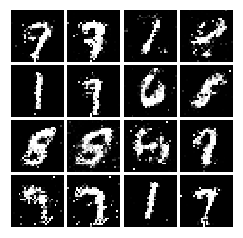


Iter: 4250, D: 0.2263, G:0.1518
Final images


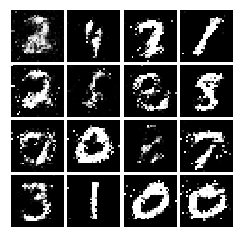

In [236]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

In [ ]:
##This inline question is purely based on visual observation. I cannot see, and describing this to me will give away the answer (and so my verbal descriptionist is not comfortable describing it). I have emailed Justin regarding this. 

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [237]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x, (tf.shape(x)[0], 28, 28, 1))
        a1 = tf.layers.conv2d(x, 32, 5)
        a2 = leaky_relu(a1, alpha = 0.01)
        a3 = tf.layers.max_pooling2d(a2, (2,2), 2)
        a4 = tf.layers.conv2d(a3, 64, 5)
        a5 = leaky_relu(a4, alpha = 0.01)
        a6 = tf.layers.max_pooling2d(a5, (2,2), 2)
        #a7 = tf.contrib.layers.flatten(a6)
        a7 = tf.reshape(a6, (tf.shape(x)[0], 1024))
        a8 = tf.layers.dense(a7, 1024)
        a9 = leaky_relu(a8, alpha = 0.01)
        logits = tf.layers.dense(a9, 1)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [238]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        a1 = tf.layers.dense(z, 1024)
        a2 = tf.nn.relu(a1)
        a3 = tf.layers.batch_normalization(a2, training=True)
        a4 = tf.layers.dense(a3, 6272)
        a5 = tf.nn.relu(a4)
        a6 = tf.layers.batch_normalization(a5, training=True)
        a7 = tf.reshape(a6, (tf.shape(z)[0], 7, 7, 128))
        a8 = tf.layers.conv2d_transpose(a7, 64, 4, strides=(2, 2), padding='same', activation = tf.nn.relu)
        a9 = tf.layers.batch_normalization(a8, training=True)
        img = tf.layers.conv2d_transpose(a9, 1, 4, strides=(2, 2), padding='same', activation = tf.tanh)
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [239]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

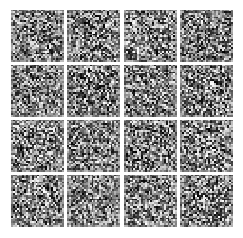


Iter: 0, D: 1.383, G:0.525
Iter: 50, D: 2.244, G:2.507
Iter: 100, D: 0.8919, G:1.041
Iter: 150, D: 0.9796, G:1.142
Iter: 200, D: 1.026, G:1.378


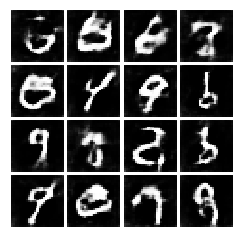


Iter: 250, D: 1.098, G:0.6149
Iter: 300, D: 1.154, G:0.9694
Iter: 350, D: 1.226, G:0.889
Iter: 400, D: 1.125, G:0.9174
Iter: 450, D: 1.142, G:0.8963


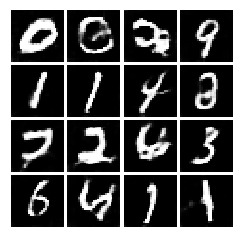


Iter: 500, D: 1.352, G:0.4608
Iter: 550, D: 1.113, G:1.003
Iter: 600, D: 1.152, G:0.7658
Iter: 650, D: 1.276, G:1.666
Iter: 700, D: 1.169, G:1.011


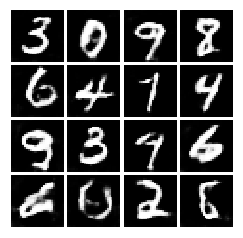


Iter: 750, D: 1.176, G:0.8772
Iter: 800, D: 1.189, G:1.048
Iter: 850, D: 1.299, G:1.588
Iter: 900, D: 1.117, G:1.046
Iter: 950, D: 1.2, G:1.179


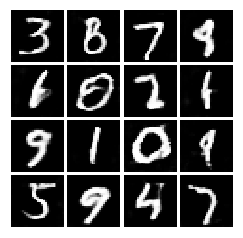


Iter: 1000, D: 1.146, G:0.9325
Iter: 1050, D: 1.106, G:0.7136
Iter: 1100, D: 1.169, G:0.7787
Iter: 1150, D: 1.177, G:0.9128
Iter: 1200, D: 1.158, G:1.031


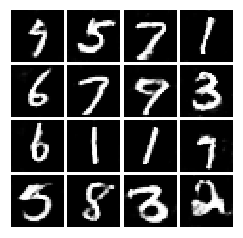


Iter: 1250, D: 1.411, G:0.8465
Iter: 1300, D: 1.195, G:1.318
Iter: 1350, D: 1.191, G:0.9879
Iter: 1400, D: 1.161, G:0.8239
Iter: 1450, D: 1.158, G:1.055


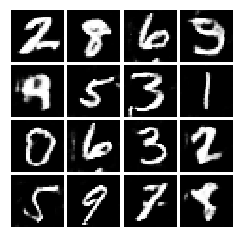


Iter: 1500, D: 1.251, G:0.8345
Iter: 1550, D: 1.208, G:0.9015
Iter: 1600, D: 1.265, G:1.035
Iter: 1650, D: 1.127, G:1.031
Iter: 1700, D: 1.196, G:0.7989


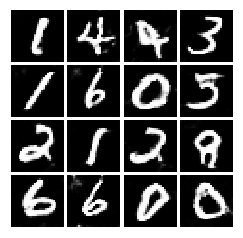


Iter: 1750, D: 1.027, G:1.073
Iter: 1800, D: 1.094, G:1.098
Iter: 1850, D: 1.123, G:0.9699
Iter: 1900, D: 1.065, G:0.8238
Iter: 1950, D: 1.064, G:1.031


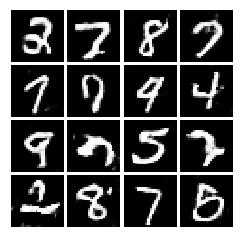


Iter: 2000, D: 1.008, G:1.111
Iter: 2050, D: 1.231, G:1.893
Iter: 2100, D: 1.128, G:1.625
Final images


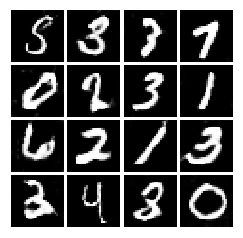

In [240]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

In [ ]:
##This inline question is purely based on visual observation. I cannot see, and describing this to me will give away the answer (and so my verbal descriptionist is not comfortable describing it). I have emailed Justin regarding this. 

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [ ]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        pass
        return logits
test_discriminator(3411649)

In [ ]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [ ]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = 0
    x_hat = 0

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = None

    grad_norm = None
    grad_pen = None



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)